In [49]:
from __future__ import print_function
from apiclient.discovery import build
from oauth2client.service_account import ServiceAccountCredentials
from datetime import datetime, timedelta
from sklearn import preprocessing
import gspread, json
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf 
import numpy as np

%matplotlib inline

In [103]:
with open('api_keys.json') as json_file:
    keys = json.load(json_file)

    
def get_gsheet(RANGENAME):
    ### Retrieve sheet data using OAuth credentials and Google Python API.
    SPREADSHEET_ID = keys["sheet"]
    scopes = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
    creds = ServiceAccountCredentials.from_json_keyfile_name('client_secret.json', scopes)
    service = build('sheets', 'v4', credentials=creds)
    sheet = service.spreadsheets()
    result = sheet.values().get(spreadsheetId=SPREADSHEET_ID,
                                    range=RANGENAME).execute()
    df = gsheet2df(result)
    return df

def gsheet2df(gsheet):
    """ Converts Google sheet data to a Pandas DataFrame.
    Note: This script assumes that your data contains a header file on the first row!
    Also note that the Google API returns 'none' from empty cells - in order for the code
    below to work, you'll need to make sure your sheet doesn't contain empty cells,
    or update the code to account for such instances.
    """
    header = gsheet.get('values', [])[0]   # Assumes first line is header!
    values = gsheet.get('values', [])[1:]  # Everything else is data.
    if not values:
        print('No data found.')
    else:
        all_data = []
        for col_id, col_name in enumerate(header):
            column_data = []
            for row in values:
                column_data.append(row[col_id])
            ds = pd.Series(data=column_data, name=col_name)
            all_data.append(ds)
        df = pd.concat(all_data, axis=1)
        return df
    
def df_clean(df, names=None):
    # Get the dataframe, drop all the duplicates and specified columns (in a string array)
    df_cleaned = df.drop_duplicates()
    if names is not None: # drop columns if they are not useful
        df_cleaned.drop(columns=names, inplace=True)
    return df_cleaned

def sheet_timestamp(df, form):
    # parse the date string into datetime object using the specified format
    df['date'] = df['date'].apply(lambda x: 
                        datetime.strptime(x,form))
    df['timestamp'] = df['date'].apply(lambda x: datetime.timestamp(x)) #timestamp in the unix format
    df.sort_values(by=['timestamp'], inplace=True)
    df = df.reindex(range(df.shape[0]))
    return df

def to_numeric(df, names):
    # ensure the specified columns are numeric values for data plotting
    for name in names:
        df[name] = pd.to_numeric(df[name])
    return df

def standardising(data):
    #standardising the data array
    if (max(data)-min(data)) < 0.000001:
        return data
    else:
        scale = 1/(max(data)-min(data))
        data_scaled = scale*data - min(data)*scale
        return data_scaled

def data_standardising(df, names=None):
    if names is None:
        for key in df.keys():
            if df[key].dtype == 'int64' or df[key].dtype == 'float64':
                df[key+" (std)"] = standardising(df[key])
    else:
        for name in names:
            if df[name].dtype == 'int64' or df[name].dtype == 'float64':
                df[name+" (std)"] = standardising(df[name])
    return df

def adjust_time(df, base):
    df = df[df['timestamp']>=base]
    df['timestamp'] = df['timestamp']-base
    return df

# def moving_average(series, step):
#     print("array length: ", len(series))
#     data = []
#     average = []
#     for i in range(len(series)):
#         print("position: ", i)
#         if i < step:
#             data.append(series[i])
# #             print("current length: ", len(data))
#         else:
#             data.pop(0)
#             data.append(series[i])
# #             print("current length: ", len(data))
#         avg = np.mean(data)
#         average.append(avg)
#     return average

# 1. Preprocessing
Getting the data from cloud storage and clean it up for analysis

In [4]:
## Get all four datasets from the google sheets used for data storage

HSI = get_gsheet("HSI")
HKD = get_gsheet("HKD")
WEATHER_HKO = get_gsheet("Weather")
WEATHER_DS = get_gsheet("Weather2")

print("df sizes before cleaning: ")
print("HSI: ", HSI.shape)
print("HKD: ", HKD.shape)
print("Weather HKO: ", WEATHER_HKO.shape)
print("Weather DS: ", WEATHER_DS.shape)

## Both weather APIs uses something known as "icon"
HKO_icons = {
    50: 'Sunny',
    51: 'Sunny Periods',
    52: 'Sunny Intervals',
    53: 'Sunny Periods with a Few Showers',
    54: 'Sunny Intervals with Showers',
    60: 'Cloudy',
    61: 'Overcast',
    62: 'Light Rain',
    63: 'Rain',
    64: 'Heavy Rain',
    65: 'Thunderstorms',
    70: 'Fine (Night)',
    71: 'Fine (Night)',
    72: 'Fine (Night)',
    73: 'Fine (Night)',
    74: 'Fine (Night)',
    75: 'Fine (Night)',
    76: 'Mainly Cloudy (Night)',
    77: 'Mainly Fine (Night)',
    80: 'Windy',
    81: 'Dry',
    82: 'Humid',
    83: 'Fog',
    84: 'Mist',
    85: 'Haze',
    90: 'Hot',
    91: 'Warm',
    92: 'Cool',
    93: 'Cold'
}
# Map these two different sets of icons together
DS_map = {
    'clear-day': 'Sunny',
    'clear-night': 'Mainly Fine (Night)',
    'rain': 'Rain',
    'snow': 'Snow',
    'sleet': 'Sleet',
    'wind': 'Windy',
    'fog': 'Fog',
    'cloudy': 'Overcast',
    'partly-cloudy-day': 'Cloudy',
    'partly-cloudy-night': 'Mainly Cloudy (Night)' 
}

df sizes before cleaning: 
HSI:  (8255, 6)
HKD:  (8781, 5)
Weather HKO:  (381, 5)
Weather DS:  (441, 5)


In [112]:
# Cleaning out the duplicates and data arrays that are not useful to analysis
HSI_cleaned = df_clean(HSI,['2. high', '3. low', '5. volume'])
HKD_cleaned = df_clean(HKD, ['2. high', '3. low'])
WHKO_cleaned = df_clean(WEATHER_HKO)
WDS_cleaned = df_clean(WEATHER_DS)
HSI_cleaned.loc[155:160]

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,date,1. open,4. close
155,2019-12-30 14:38:00,28347.5898,28346.9805
156,2019-12-30 14:39:00,28349.0996,28346.7695
157,2019-12-30 16:08:00,28316.2207,28316.2207
159,2019-12-30 15:39:00,28307.25,28307.7793
160,2019-12-30 15:40:00,28305.5293,28297.1699


In [113]:
print("df sizes after cleaning: ")
print("HSI: ", HSI_cleaned.shape)
print("HKD: ", HKD_cleaned.shape)
print("Weather HKO: ", WHKO_cleaned.shape)
print("Weather DS: ", WDS_cleaned.shape)

# adjusting the timestamp columns of all data
form = '%Y-%m-%d %H:%M:%S'
sheet_timestamp(HSI_cleaned, form)
sheet_timestamp(HKD_cleaned, form)
sheet_timestamp(WHKO_cleaned, form)
sheet_timestamp(WDS_cleaned, form)

# making sure the data are numbers
HSI_cleaned = to_numeric(HSI_cleaned, ['1. open', '4. close'])
HKD_cleaned = to_numeric(HKD_cleaned, ['1. open', '4. close'])
WHKO_cleaned = to_numeric(WHKO_cleaned, ['temperature', 'humidity', 'rainfall', 'icon'])
WDS_cleaned = to_numeric(WDS_cleaned, ['temperature', 'humidity', 'rainfall'])

# open and close per minute data is still not that useful, the average is more representative:
HSI_cleaned['value'] = (HSI_cleaned['1. open']+HSI_cleaned['4. close'])/2
HSI_cleaned.drop(columns=['1. open', '4. close'], inplace=True)
HKD_cleaned['value'] = (HKD_cleaned['1. open']+HKD_cleaned['4. close'])/2
HKD_cleaned.drop(columns=['1. open', '4. close'], inplace=True)
# the financial data also has a higher sampled frequency and volitility, a moving average will help with analysis
HSI_cleaned['moving-average'] = HSI_cleaned['value'].rolling(10,min_periods=1).mean()
HKD_cleaned['moving-average'] = HKD_cleaned['value'].rolling(10,min_periods=1).mean()

# mapping the weather icons for consistency
WHKO_cleaned['icon'].replace(HKO_icons, inplace=True)
WDS_cleaned['icon'].replace(DS_map, inplace=True)
WHKO_cleaned.head()

df sizes after cleaning: 
HSI:  (2729, 3)
HKD:  (4420, 3)
Weather HKO:  (77, 5)
Weather DS:  (430, 5)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-pac

,date,temperature,humidity,rainfall,icon,timestamp
0,2019-12-31 07:00:00,20,90,0,Cloudy,1.577776e+09
3,2019-12-31 08:00:00,20,88,0,Cloudy,1.577779e+09
4,2019-12-31 09:00:00,20,88,0,Cloudy,1.577783e+09
5,2019-12-31 10:00:00,20,89,0,Cloudy,1.577786e+09
8,2019-12-31 11:00:00,19,87,0,Cloudy,1.577790e+09


In [114]:
HSI_cleaned.head()

,date,timestamp,value,moving average
0,2019-12-30 09:31:00,1.577698e+09,28223.010,28223.010000
1,2019-12-30 09:32:00,1.577698e+09,28208.170,28215.590000
2,2019-12-30 09:33:00,1.577698e+09,28203.070,28211.416667
3,2019-12-30 09:34:00,1.577698e+09,28199.595,28208.461250
4,2019-12-30 09:35:00,1.577698e+09,28198.300,28206.429000


In [116]:
# normalising data
data_standardising(HSI_cleaned, ['moving-average', 'value'])
data_standardising(HKD_cleaned, ['moving-average', 'value'])
data_standardising(WHKO_cleaned, ['temperature', 'humidity', 'rainfall'])
data_standardising(WDS_cleaned, ['temperature', 'humidity', 'rainfall'])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,temperature,humidity,rainfall,icon,timestamp,temperature (std),humidity (std),rainfall (std)
0,2019-12-31 07:00:00,18.11,87,0.14,Overcast,1.577776e+09,0.196296,0.756757,0.8750
1,2019-12-31 07:10:00,18.07,87,0.14,Overcast,1.577776e+09,0.191358,0.756757,0.8750
2,2019-12-31 07:20:00,18.07,86,0.15,Overcast,1.577777e+09,0.191358,0.729730,0.9375
3,2019-12-31 07:30:00,18.09,85,0.15,Overcast,1.577777e+09,0.193827,0.702703,0.9375
4,2019-12-31 07:40:00,18.12,84,0.15,Overcast,1.577778e+09,0.197531,0.675676,0.9375
5,2019-12-31 07:50:00,18.16,83,0.15,Overcast,1.577779e+09,0.202469,0.648649,0.9375
6,2019-12-31 08:00:00,18.19,82,0.14,Overcast,1.577779e+09,0.206173,0.621622,0.8750
7,2019-12-31 08:10:00,18.23,81,0.13,Overcast,1.577780e+09,0.211111,0.594595,0.8125
8,2019-12-31 08:20:00,18.25,80,0.10,Overcast,1.577780e+09,0.213580,0.567568,0.6250
9,2019-12-31 08:30:00,18.28,80,0.08,Overcast,1.577781e+09,0.217284,0.567568,0.5000


In [117]:
# find the common starting point of the data
base_time = max(min(HSI_cleaned['timestamp']),min(HKD_cleaned['timestamp']),min(WHKO_cleaned['timestamp']),min(WDS_cleaned['timestamp']))
adjust_time(HSI_cleaned, base_time)
adjust_time(HKD_cleaned, base_time)
adjust_time(WHKO_cleaned, base_time)
adjust_time(WDS_cleaned, base_time)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:83: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,date,temperature,humidity,rainfall,icon,timestamp,temperature (std),humidity (std),rainfall (std)
0,2019-12-31 07:00:00,18.11,87,0.14,Overcast,0.0,0.196296,0.756757,0.8750
1,2019-12-31 07:10:00,18.07,87,0.14,Overcast,600.0,0.191358,0.756757,0.8750
2,2019-12-31 07:20:00,18.07,86,0.15,Overcast,1200.0,0.191358,0.729730,0.9375
3,2019-12-31 07:30:00,18.09,85,0.15,Overcast,1800.0,0.193827,0.702703,0.9375
4,2019-12-31 07:40:00,18.12,84,0.15,Overcast,2400.0,0.197531,0.675676,0.9375
5,2019-12-31 07:50:00,18.16,83,0.15,Overcast,3000.0,0.202469,0.648649,0.9375
6,2019-12-31 08:00:00,18.19,82,0.14,Overcast,3600.0,0.206173,0.621622,0.8750
7,2019-12-31 08:10:00,18.23,81,0.13,Overcast,4200.0,0.211111,0.594595,0.8125
8,2019-12-31 08:20:00,18.25,80,0.10,Overcast,4800.0,0.213580,0.567568,0.6250
9,2019-12-31 08:30:00,18.28,80,0.08,Overcast,5400.0,0.217284,0.567568,0.5000


# 2. Basic Time Series Data Analysis

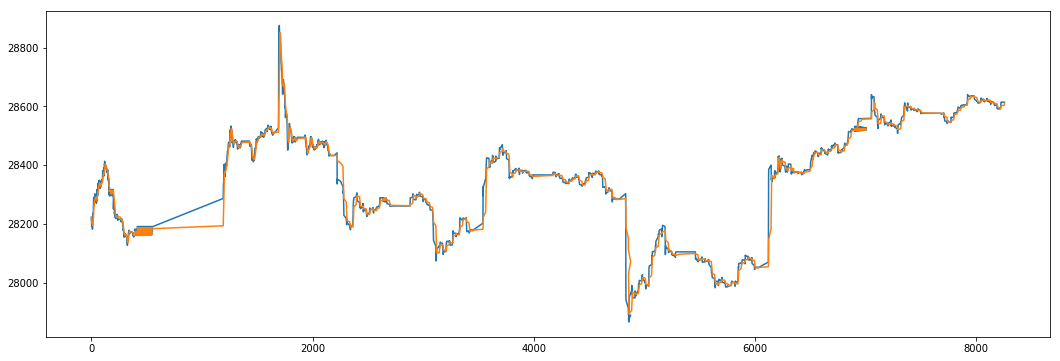

In [128]:
fig1 = plt.figure(figsize = (18,6))

plot = plt.plot(HSI_cleaned['value'])
plot = plt.plot(HSI_cleaned['moving average'])
plt.show()

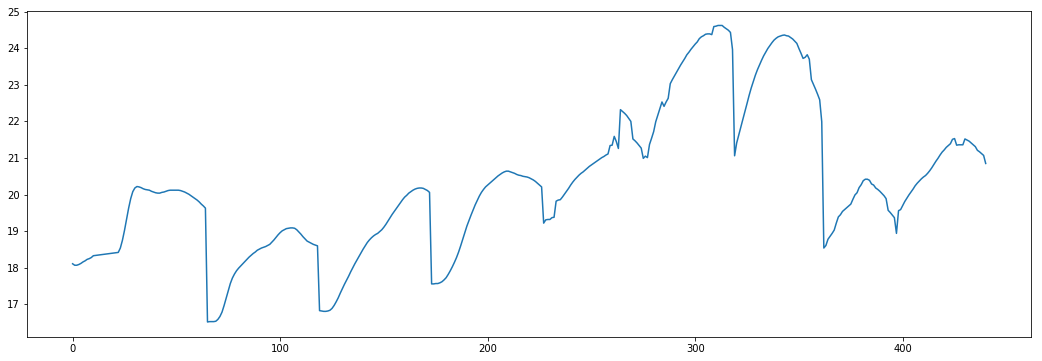

In [126]:
fig2 = plt.figure(figsize = (18,6))

plot = plt.plot(WDS_cleaned['temperature'])
plt.show()

In [121]:
# merge the useful dataframes using the common timestamps
merged = pd.merge(HSI_cleaned, WDS_cleaned, on="timestamp")

Cloudy      116
Sunny        72
Overcast     51
Name: icon, dtype: int64


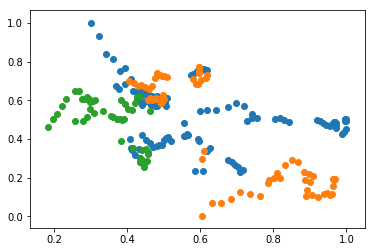

In [125]:
print(merged['icon'].value_counts())
cloudy = merged[merged['icon']=='Cloudy']
sunny = merged[merged['icon']=='Sunny']
overcast = merged[merged['icon']=='Overcast']

# model = smf.ols(formula='open (std)~temperature (std)', data=merged).fit()
# b, a = model.params  # extracting model parameters
# y_predicted = a * crime_data['PctBSorMore'] + b  # calculating the line of best fit


plt.figure()
# plt.plot(merged['temperature (std)'], y_predicted)
plt.scatter(cloudy['temperature (std)'], cloudy['moving average (std)'])
plt.scatter(sunny['temperature (std)'], sunny['moving average (std)'])
plt.scatter(overcast['temperature (std)'], overcast['moving average (std)'])
plt.show()

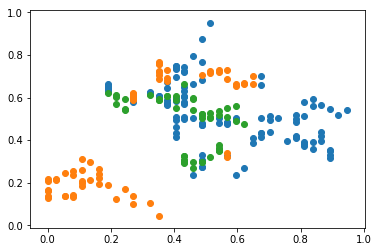

In [31]:
plt.figure()
plt.scatter(cloudy['humidity (std)'], cloudy['open (std)'])
plt.scatter(sunny['humidity (std)'], sunny['open (std)'])
plt.scatter(overcast['humidity (std)'], overcast['open (std)'])
plt.show()